In [ ]:
# Parameters
seed = 42
rewards = [-100, -20, 0, 20, 140]
colors = ["red", "orange", "gray", "yellow", "green"]
min_al = 3
from_to_str = {"(0,0)": [1, 2, 3], "(0,1)": [0], "(1,0)": [1, 2], "(1,1)": [2, 3], "(1,2)": [2, 3], "(2,0)": [1, 2], "(2,1)": [1, 2], "(2,2)": [2, 3], "(2,3)": [2, 3], "(3,0)": [3, 4], "(3,1)": [3, 4], "(3,2)": [3, 4], "(3,3)": [3, 4]}
output_folder = "../../data/dev"
n_train = 1000
n_test = 100
n_steps = 8
dataset_name = "dev"


In [96]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import string
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from rn.utils.utils import save_json, make_dir

# yaml does not support objects with tuples as keys. This is a hacky workaround.
from_to = {(int(k[1]),int(k[3])):v for k,v in from_to_str.items()}

make_dir(output_folder)

test_file = os.path.join(output_folder, 'test.json')
train_file = os.path.join(output_folder, 'train.json')

random.seed(seed)
np.random.seed(seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
def add_link(G, a, b):
    a_s = G.nodes[a]['stage']
    b_s = G.nodes[b]['stage']
    reward_idx = random.choice(from_to[(a_s,b_s)])
    G.add_edge(a, b, reward=rewards[reward_idx], reward_idx=reward_idx, color=colors[reward_idx])

def new_node(G, stage):
    idx = len(G)
    name = string.ascii_lowercase[idx%len(string.ascii_lowercase)]+string.ascii_lowercase[idx//len(string.ascii_lowercase)]
    G.add_node(idx, name=name, stage=stage)
    return idx

def filter_node(G, node, current_node):
    if node == current_node:
        return []
    if node in G[current_node]:
        return []
    a_s = G.nodes[current_node]['stage']
    b_s = G.nodes[node]['stage']
    return from_to.get((a_s, b_s), [])


def get_min_incoming(G, nodes):
    in_de = [G.in_degree(n) for n in nodes]
    min_in_de = min(in_de)
    return [n for n, ind in zip(nodes, in_de) if ind == min_in_de]

    
def find_nodes(G, current_node):
    return [
        n
        for n in G.nodes() 
        for _ in filter_node(G, n, current_node)
    ]


def sample_network():
    G = nx.DiGraph()

    node_stages = {
        0: 4,
        1: 1,
        2: 1,
        3: 1
    }

    for i in range(3):
        stage = random.randint(0,3)
        node_stages[stage] += 1

    for stage, n in node_stages.items():
        for i in range(n):
            new_node(G, stage)

    start_node = 0

    n_edges_per_node = 2

    for i in range(60):
        current_node = start_node
        for j in range(8):
            if len(G.out_edges(current_node)) < n_edges_per_node:
                potential_nodes = find_nodes(G, current_node)
                potential_nodes = get_min_incoming(G, potential_nodes)
                next_node = random.choice(potential_nodes)
                add_link(G, current_node, next_node)
                if len(G.edges) == (len(G.nodes) * n_edges_per_node):
                    break
            else:
                next_node = random.choice([e[1] for e in G.out_edges(current_node)])
            current_node = next_node
    return G

## Display an example network

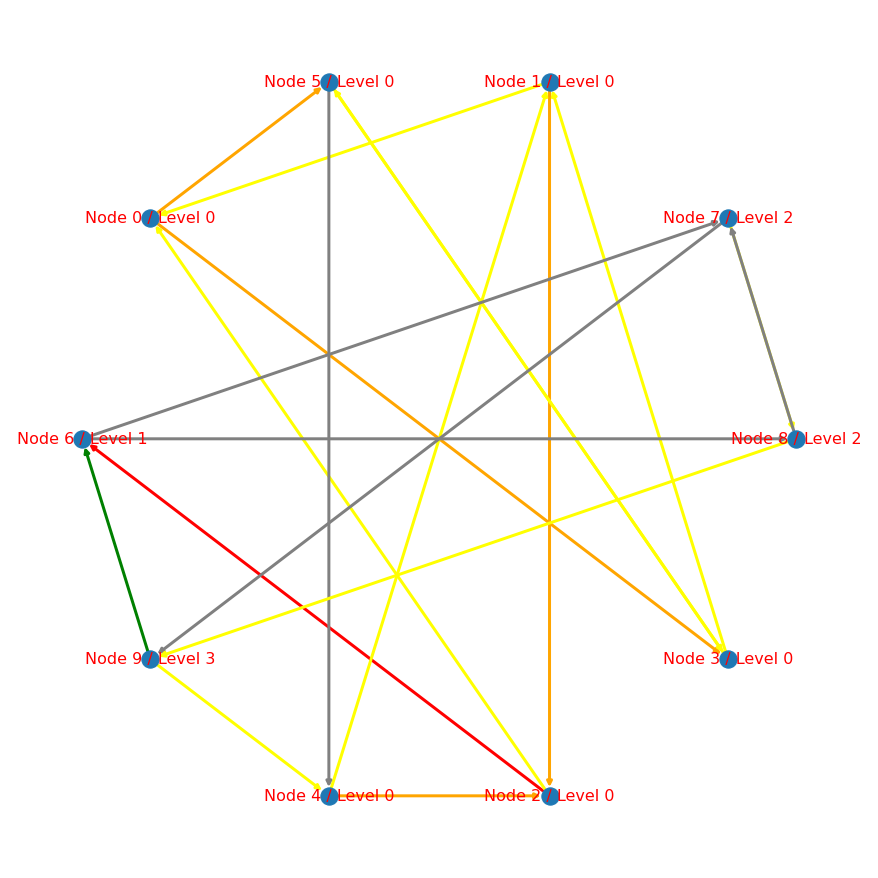

In [98]:
G = sample_network()

pos = nx.circular_layout(G)
pos = list(pos.values())
random.shuffle(pos)
pos = {
    n: p for n, p in enumerate(pos)
}

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
labeldict={n: f"Node {n} / Level {d['stage']}" for n, d in G.nodes(data=True)}

plt.figure(figsize=(12,12)) 
nx.draw(G, pos, edge_color=colors, labels=labeldict, font_size=16, font_color="red", width=3)

# Create Network Objects

In [99]:
from rn.pruning_model.model import parse_network, calculate_q_value, calculate_trace
import torch as th

def parse_node(name, pos_map, id, **kwargs):
    return {
        'id': id,
        'displayName': name,
        **pos_map[id]
    }


def parse_link(source, target, reward, reward_idx, **_):
    return {
        "reward": reward,
        "rewardIdx": reward_idx,
        "sourceId": source,
        "targetId": target
    }


def create_base_network_object(pos_map, starting_node=0, *, nodes, links, network_id, n_steps, **kwargs):
    return {
        'type': 'network',
        'version': 'four-rewards-v3',
        'network_id': network_id,
        'actions': [parse_link(**l) for l in links],
        'nodes': [parse_node(pos_map=pos_map, **n) for n in nodes],
        'n_steps': n_steps,
        'starting_node': starting_node}


def get_max_reward(network):
    edges, rewards = parse_network(network)
    # calculate q value for gamma = 0 (no pruning)
    Q = calculate_q_value(edges, rewards, n_steps=network['n_steps'], n_nodes=len(network['nodes']), gamma=0)
    # get trace corresponding to q values
    edge_trace, node_trace = calculate_trace(Q, edges, starting_node=network['starting_node'])
    reward_trace = rewards[edge_trace]
    max_reward = reward_trace.sum()

    max_reward2 = th.where(network['starting_node'] == edges[:, 0], Q[0], th.tensor(-10000.)).max()

    if max_reward2 != max_reward:
        print('Rewards do not match')
        print(network['network_id'], max_reward2, max_reward)

    # TODO: check why this assertion is not always valid.
    # assert max_reward == max_reward2
    return max_reward2
    

def add_max_reward(network):
    return {
        **network,
        'max_reward': get_max_reward(network).item()
    }

def create_network_object(**kwargs):
    network = create_base_network_object(**kwargs)
    return add_max_reward(network)


## Store networks

In [100]:
# create positions (x,y coordinates) for network nodes
G = sample_network()
network = nx.json_graph.node_link_data(G)
pos = nx.circular_layout(G)
pos_map = {
    k: {'x': v[0], 'y': v[0]}
    for k, v in pos.items()
}

# sample and store training networks
networks = []
for i in range(n_train):
    network_id = f'{dataset_name}_train_{i}'
    G = sample_network()
    network = nx.json_graph.node_link_data(G)
    networks.append(create_network_object(pos_map=pos_map, n_steps=n_steps, network_id=network_id, **network))
save_json(networks, train_file)


# sample and store test networks
networks = []
for i in range(n_test):
    network_id = f'{dataset_name}_train_{i}'
    G = sample_network()
    network = nx.json_graph.node_link_data(G)
    networks.append(create_network_object(pos_map=pos_map, n_steps=n_steps, network_id=network_id, **network))
save_json(networks, test_file)   

Rewards do not match
dev_train_614 tensor(200.) tensor(180)
